<a href="https://colab.research.google.com/github/CanKeles5/SequenceModels/blob/main/Univariate_Time_Series_Forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

In [ ]:
def parser(x):
	return datetime #.strptime('190'+x, '%Y-%m')

In [2]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [3]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [4]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [5]:
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [6]:
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [42]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])

  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
  return model

In [43]:
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [44]:
series = read_csv('/content/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True) #, date_parser=parser

In [45]:
raw_values = series.values
diff_values = difference(raw_values, 1)

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

train, test = supervised_values[0:-120], supervised_values[-120:]

scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
lstm_model = fit_lstm(train_scaled, 1, 10, 4)

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

In [29]:
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=1, Predicted=8.217833, Expected=8.600000
Month=2, Predicted=7.705628, Expected=7.600000
Month=3, Predicted=7.161131, Expected=10.400000
Month=4, Predicted=8.806106, Expected=10.300000
Month=5, Predicted=8.812278, Expected=7.500000
Month=6, Predicted=7.201121, Expected=3.000000
Month=7, Predicted=4.241652, Expected=5.300000
Month=8, Predicted=5.971476, Expected=10.500000
Month=9, Predicted=8.906944, Expected=14.600000
Month=10, Predicted=10.896213, Expected=12.600000
Month=11, Predicted=9.879667, Expected=9.800000
Month=12, Predicted=8.381999, Expected=7.200000
Month=13, Predicted=6.969048, Expected=10.100000
Month=14, Predicted=8.865401, Expected=10.400000
Month=15, Predicted=9.190251, Expected=3.700000
Month=16, Predicted=4.686508, Expected=7.300000
Month=17, Predicted=7.241206, Expected=11.600000
Month=18, Predicted=9.647928, Expected=16.300000
Month=19, Predicted=11.950071, Expected=9.600000
Month=20, Predicted=8.191628, Expected=6.800000
Month=21, Predicted=6.593252, Expected

In [30]:
rmse = sqrt(mean_squared_error(raw_values[-120:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.771


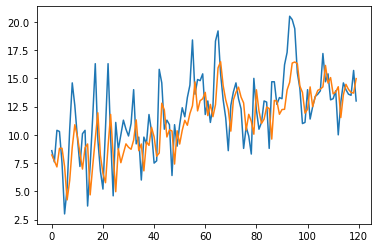

In [32]:
pyplot.plot(raw_values[-120:])
pyplot.plot(predictions)
pyplot.show()